<a href="https://colab.research.google.com/github/RafaelCerq/EstudosPython/blob/main/GansRedesAdvers%C3%A1riasGenerativas/Gans_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Deep Convolutional GANs

## Importação das bibliotecas


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.9.2'

## Carregamento e pré-processamento da base de dados

- MNIST é o nome da base de dados que possui os digitos escritos a mão




In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
X_treinamento.shape


(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_treinamento.shape

(60000,)

9


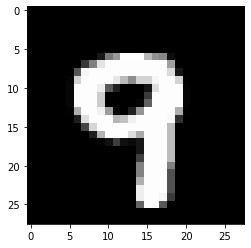

In [7]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

Incluindo número de canais ao final do vetor x_treinamento

In [8]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [9]:
X_treinamento.shape

(60000, 28, 28, 1)

In [10]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

Aplicando normalização para treinamento da rede - Ao utilizar uma GAN é recomendado utilizar escalas entre -1 e 1. (127.5 é o valor que esta no meio de 255.0)

In [11]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [12]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

Dividir a base de dados de treinamento em batch. No caso, cada batch possui 256 imagens

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size / batch_size

234.375

In [15]:
type(X_treinamento)

numpy.ndarray

Converte a base para o formato do tensorflow e dividir em batch

In [16]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow